# 뉴스 카테고리 다중분류 [프로젝트]
## 프로젝트: Vocabulary Size를 변경해서 시도해보기

In [1]:
from tensorflow.keras.datasets import reuters
import tensorflow
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import keras.backend as K

## 준비

### 모델 준비

In [2]:
def train_model(xtrain, ytrain, xtest, ytest):
    nb = MultinomialNB() # 나이브 베이즈 분류기
    cb = ComplementNB() # 컴플리먼트 나이브 베이즈 분류기
    lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000) # 로지스틱 회귀
    lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False) # 선형 서포트 벡터 머신
    tree = DecisionTreeClassifier(max_depth=10, random_state=0) # 결정 트리
    forest = RandomForestClassifier(n_estimators=5, random_state=0) # 랜덤 포레스트
    grbt = GradientBoostingClassifier(random_state=0) # 그래디언트 부스팅 트리
    voting_classifier = VotingClassifier(estimators=[ # 보팅
            ('lr', LogisticRegression(C=10000, penalty='l2', max_iter=3000)),
            ('cb', ComplementNB()),
            ('grbt', GradientBoostingClassifier(random_state=0))
    ], voting='soft', n_jobs=-1)

    model_list = [nb, cb, lr, lsvc, tree, forest, grbt, voting_classifier]

    for model in model_list:
        model.fit(xtrain, ytrain)
        pred = model.predict(xtest)
        print(f'{model.name} 모델 정확도: {accuracy_score(ytest, pred)}')

### 데이터 복원

In [3]:
word_index = reuters.get_word_index(path='reuters_word_index.json')
index_to_word = { index + 3 : word for word, index in word_index.items()
                }
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

def decode_data(x_train, x_test):
    #train 데이터 복원
    decoded_train = []
    for i in range(len(x_train)):
        tr = ' '.join([index_to_word[index] for index in x_train[i]])
        decoded_train.append(tr)
    x_train = decoded_train

    # test 데이터 복원
    decoded_test = []
    for i in range(len(x_test)):
        te = ' '.join([index_to_word[index] for index in x_test[i]])
        decoded_test.append(te)
    x_test = decoded_test

    return x_train, x_test

### 벡터화

In [4]:
def vector(x_train, x_test):
    dtmvector = CountVectorizer()  # DTM
    tfidf_transformer = TfidfTransformer()  # TF-IDF

    # train data
    x_train_dtm = dtmvector.fit_transform(x_train)
    tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
    print(x_train_dtm.shape)
    print(tfidfv.shape)

    # test data
    x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
    tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

    return tfidfv, tfidfv_test

## 1. 모든 단어 사용

### 데이터 로드

In [45]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

In [46]:
print('train data: ', len(x_train))
print('test data: ', len(x_test))

print('\n')
print(x_train[0])
print(x_test[0])

train data:  8982
test data:  2246


[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 18292, 159, 9, 1084, 363, 13, 19231, 71, 9, 16273, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 16273, 7, 748, 48, 9, 19231, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 2

In [47]:
print(y_train[0])
print(y_test[0])

3
3


In [48]:
num_classes = max(y_train) + 1
print('클래스의 수: ', num_classes)

클래스의 수:  46


### 데이터 분포 확인

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


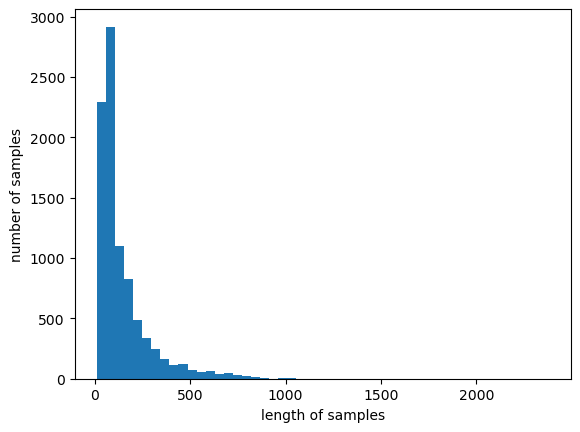

In [49]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

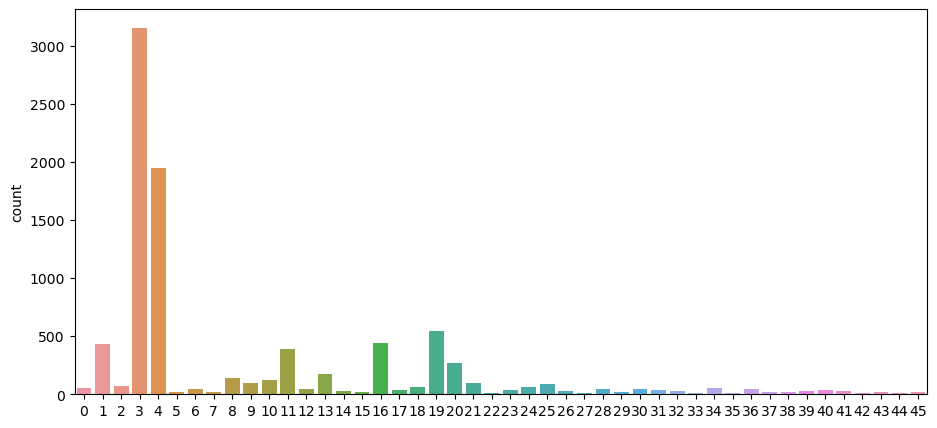

In [50]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

In [51]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


### 데이터 복원

In [52]:
x_train, x_test = decode_data(x_train, x_test)

In [53]:
print(x_train[0])
print('\n')
print(x_test[0])

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the e

### 벡터화

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [56]:
tfidfv, tfidfv_test = vector(x_train, x_test)

(8982, 26506)
(8982, 26506)


### 모델 학습

In [62]:
train_model(tfidfv, y_train, tfidfv_test, y_test)

MultinomialNB() 모델 정확도: 0.5997328584149599
ComplementNB() 모델 정확도: 0.7649154051647373
LogisticRegression(C=10000, max_iter=3000) 모델 정확도: 0.8165627782724845
LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1') 모델 정확도: 0.7876224398931434
DecisionTreeClassifier(max_depth=10, random_state=0) 모델 정확도: 0.6211041852181657
RandomForestClassifier(n_estimators=5, random_state=0) 모델 정확도: 0.6544968833481746
GradientBoostingClassifier(random_state=0) 모델 정확도: 0.7707034728406055
VotingClassifier(estimators=[('lr', LogisticRegression(C=10000, max_iter=3000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft') 모델 정확도: 0.8156723063223509


## 2. 빈도수 상위 5,000개의 단어만 사용

In [67]:
K.clear_session()

### 데이터 로드

In [68]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

In [69]:
print('train data: ', len(x_train))
print('test data: ', len(x_test))

print('\n')
print(x_train[0])
print(x_test[0])

train data:  8982
test data:  2246


[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192

In [71]:
x_train, x_test = decode_data(x_train, x_test)

In [72]:
tfidfv, tfidfv_test = vector(x_train, x_test)

(8982, 4867)
(8982, 4867)


In [73]:
train_model(tfidfv, y_train, tfidfv_test, y_test)

MultinomialNB() 모델 정확도: 0.6731967943009796
ComplementNB() 모델 정확도: 0.7707034728406055
LogisticRegression(C=10000, max_iter=3000) 모델 정확도: 0.8036509349955476
LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1') 모델 정확도: 0.7769367764915405
DecisionTreeClassifier(max_depth=10, random_state=0) 모델 정확도: 0.6179875333926982
RandomForestClassifier(n_estimators=5, random_state=0) 모델 정확도: 0.6999109528049866
GradientBoostingClassifier(random_state=0) 모델 정확도: 0.7684772929652716
VotingClassifier(estimators=[('lr', LogisticRegression(C=10000, max_iter=3000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft') 모델 정확도: 0.8103294746215495


## 3. 직접 단어 개수를 설정해서 사용

In [21]:
K.clear_session()

### 3-1. num_words = 10000

In [75]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2) # data load

In [76]:
print('train data: ', len(x_train))
print('test data: ', len(x_test))

print('\n')
print(x_train[0])
print(x_test[0])

train data:  8982
test data:  2246


[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192

In [77]:
x_train, x_test = decode_data(x_train, x_test) # 데이터 복원

In [78]:
tfidfv, tfidfv_test = vector(x_train, x_test) # 벡터화

(8982, 9670)
(8982, 9670)


In [79]:
train_model(tfidfv, y_train, tfidfv_test, y_test) # 모델 학습

MultinomialNB() 모델 정확도: 0.6567230632235085
ComplementNB() 모델 정확도: 0.7707034728406055
LogisticRegression(C=10000, max_iter=3000) 모델 정확도: 0.8098842386464826
LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1') 모델 정확도: 0.7853962600178095
DecisionTreeClassifier(max_depth=10, random_state=0) 모델 정확도: 0.6202137132680321
RandomForestClassifier(n_estimators=5, random_state=0) 모델 정확도: 0.674087266251113
GradientBoostingClassifier(random_state=0) 모델 정확도: 0.7693677649154052
VotingClassifier(estimators=[('lr', LogisticRegression(C=10000, max_iter=3000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft') 모델 정확도: 0.8156723063223509


### 3-2. num_words = 3000

In [81]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=3000, test_split=0.2) # data load

In [82]:
print('train data: ', len(x_train))
print('test data: ', len(x_test))

print('\n')
print(x_train[0])
print(x_test[0])

train data:  8982
test data:  2246


[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 2, 111, 8, 25, 109, 29, 2, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 2, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192, 510, 17, 12]


In [83]:
x_train, x_test = decode_data(x_train, x_test) # 데이터 복원

In [84]:
tfidfv, tfidfv_test = vector(x_train, x_test) # 벡터화

(8982, 2919)
(8982, 2919)


In [85]:
train_model(tfidfv, y_train, tfidfv_test, y_test) # 모델 학습

MultinomialNB() 모델 정확도: 0.6874443455031166
ComplementNB() 모델 정확도: 0.7644701691896705
LogisticRegression(C=10000, max_iter=3000) 모델 정확도: 0.7880676758682101
LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1') 모델 정확도: 0.7560106856634016
DecisionTreeClassifier(max_depth=10, random_state=0) 모델 정확도: 0.6260017809439002
RandomForestClassifier(n_estimators=5, random_state=0) 모델 정확도: 0.684772929652716
GradientBoostingClassifier(random_state=0) 모델 정확도: 0.776046304541407
VotingClassifier(estimators=[('lr', LogisticRegression(C=10000, max_iter=3000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft') 모델 정확도: 0.802760463045414


### 3-3. num_words = 15000

In [86]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=15000, test_split=0.2) # data load

In [87]:
print('train data: ', len(x_train))
print('test data: ', len(x_test))

print('\n')
print(x_train[0])
print(x_test[0])

train data:  8982
test data:  2246


[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192

In [89]:
x_train, x_test = decode_data(x_train, x_test) # 데이터 복원

In [90]:
tfidfv, tfidfv_test = vector(x_train, x_test) # 벡터화

(8982, 14227)
(8982, 14227)


In [91]:
train_model(tfidfv, y_train, tfidfv_test, y_test) # 모델 학습

MultinomialNB() 모델 정확도: 0.6331255565449688
ComplementNB() 모델 정확도: 0.7720391807658059
LogisticRegression(C=10000, max_iter=3000) 모델 정확도: 0.8143365983971504
LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1') 모델 정확도: 0.7929652715939448
DecisionTreeClassifier(max_depth=10, random_state=0) 모델 정확도: 0.6188780053428317
RandomForestClassifier(n_estimators=5, random_state=0) 모델 정확도: 0.6714158504007124
GradientBoostingClassifier(random_state=0) 모델 정확도: 0.7702582368655387
VotingClassifier(estimators=[('lr', LogisticRegression(C=10000, max_iter=3000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft') 모델 정확도: 0.8147818343722173


|모델/num_words|all|3000|5000|10000|15000|
|:---:|:---:|:---:|:---:|:---:|:---:|
|나이브 베이즈 분류기|0.600|**0.687**|0.673|0.657|0.633|
|컴플리먼트 나이브 베이즈 분류기|0.765|0.764|0.771|0.771|**0.772**|
|로지스틱 회귀|<span style="color:red">**0.817**</span>|0.788|0.804|0.810|0.814|
|선형 서포트 벡터 머신|0.788|0.756|0.777|0.785|**0.793**|
|결정 트리|0.621|**0.626**|0.618|0.620|0.619|
|랜덤 포레스트|0.654|0.685|**0.700**|0.674|0.671|
|그래디언트 부스팅 트리|0.771|**0.776**|0.768|0.769|0.770|
|보팅|**0.816**|0.803|0.810|**0.816**|0.815|

## 4. RNN

In [24]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)
print(len(x_train), len(x_test))
max_len = max(len(l) for l in np.concatenate((x_train, x_test), axis=0))
print('max_len : ', max_len)

8982 2246
max_len :  2376


In [25]:
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

In [26]:
vocab_size = len(index_to_word)
word_vector_dim = 128

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(46, activation='softmax'))

mc = ModelCheckpoint("reuters.h5",monitor='val_accuracy', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=100, callbacks=[es, mc], batch_size=64, validation_split=0.3, verbose=1)

Epoch 1/100
99/99 [==============================] - 12s 110ms/step - loss: 2.4494 - accuracy: 0.3784 - val_loss: 1.8723 - val_accuracy: 0.4902
Epoch 2/100
99/99 [==============================] - 11s 107ms/step - loss: 1.8147 - accuracy: 0.5153 - val_loss: 1.8500 - val_accuracy: 0.4831
Epoch 3/100
99/99 [==============================] - 11s 107ms/step - loss: 1.7143 - accuracy: 0.5389 - val_loss: 1.7131 - val_accuracy: 0.5429
Epoch 4/100
99/99 [==============================] - 11s 107ms/step - loss: 1.6198 - accuracy: 0.5639 - val_loss: 1.6712 - val_accuracy: 0.5622
Epoch 5/100
99/99 [==============================] - 11s 107ms/step - loss: 1.3950 - accuracy: 0.6219 - val_loss: 1.7819 - val_accuracy: 0.5607
Epoch 6/100
99/99 [==============================] - 11s 108ms/step - loss: 1.2368 - accuracy: 0.6698 - val_loss: 1.5116 - val_accuracy: 0.6397
Epoch 7/100
99/99 [==============================] - 11s 108ms/step - loss: 0.9888 - accuracy: 0.7376 - val_loss: 1.5791 - val_accuracy:

In [27]:
model.evaluate(x_test, y_test)

71/71 [==============================] - 2s 31ms/step - loss: 1.8498 - accuracy: 0.6278


[1.8498387336730957, 0.6277827024459839]